## Required Packages

In [0]:
import requests
import json
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## **Query URL**

In [0]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
(
  node["amenity"="restaurant"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="restaurant"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="restaurant"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="college"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="college"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="college"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="university"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="university"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="university"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="fuel"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="fuel"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="fuel"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="bank"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="bank"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="bank"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="hospital"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="hospital"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="hospital"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="cinema"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="cinema"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="cinema"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  
  node["amenity"="marketplace"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  way["amenity"="marketplace"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
  relation["amenity"="marketplace"](28.52089106940537,77.17071533203125,28.57148207754995,77.26006507873535);
);
out body;
"""

## **Network Response**

In [0]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

### **Parsing JSON**

In [0]:
# Collect coords into list
coords = []
for element in data['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))

# Convert coordinates into numpy array

## **Creating Elbow Curve for Kmeans Clustering of Spatial Data inorder to identify the key POIs** 

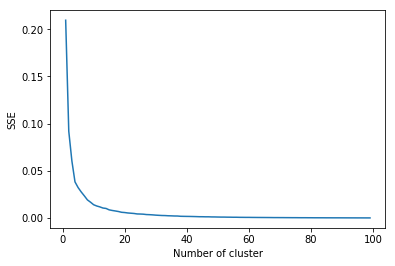

In [0]:
sse = {}
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, max_iter=10000).fit(coords)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

## **Clusting Co-ordinates and finding cluster centers**

In [0]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

elbow_val = 50
kmeans = doKmeans(coords, elbow_val)

## **Plotting Points based on overfitted cluster**

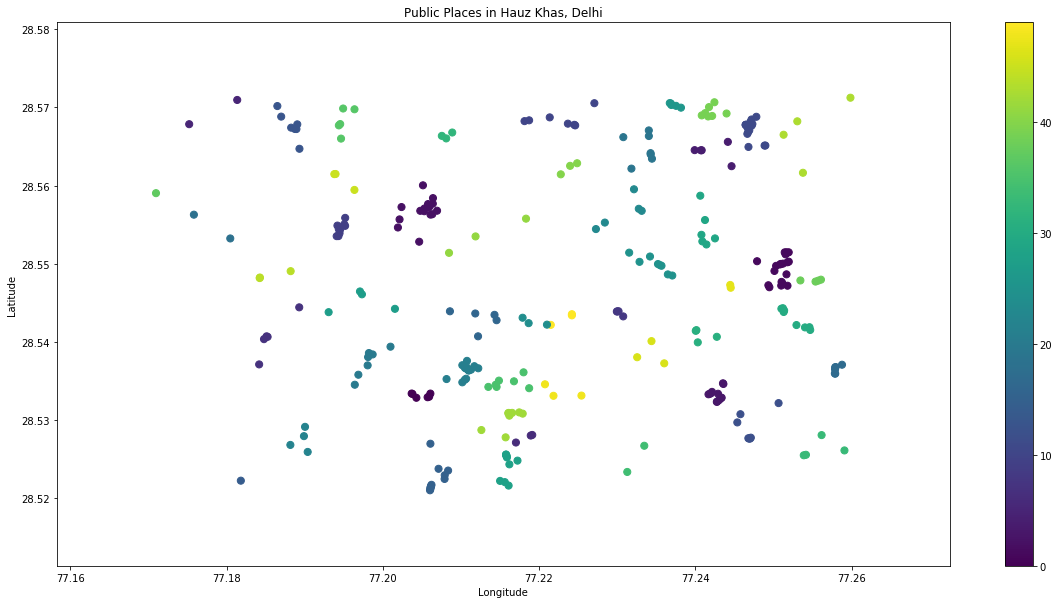

In [0]:
target = kmeans[0]
X = np.array(coords)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=target,s=50)
ax.set_title('Public Places in Hauz Khas, Delhi')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.axis('equal')
plt.colorbar(scatter)

## **Preparing to remove clusters formed due to lesser number of points than mean number of points per cluster**

In [0]:
data = pd.DataFrame(data=X)
data[2] = kmeans[0]
data['count'] = data.groupby(by=[2])[2].agg('count').reset_index(drop=True)
mean_val = data['count'].mean()
new_data = data[data['count'] > mean_val]

## **Visualizing after Removal**

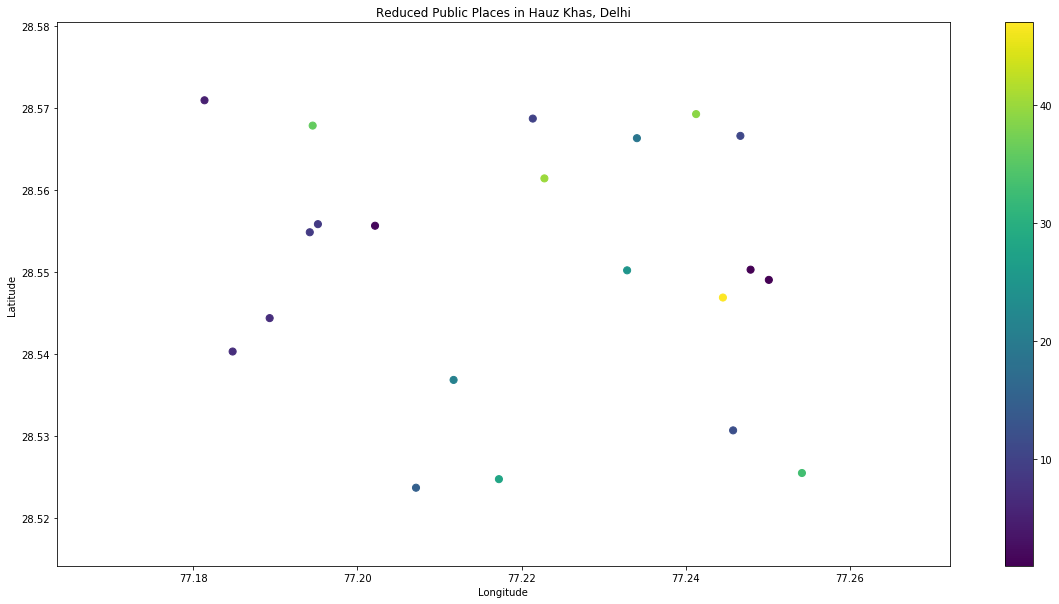

In [0]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(new_data[0],new_data[1],c=new_data[2],s=50)
ax.set_title('Reduced Public Places in Hauz Khas, Delhi')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.axis('equal')
plt.colorbar(scatter)

In [0]:
dump = new_data[[0,1]]

dump = dump.rename(columns={0: "longitude", 1: "latitude"})
dump.head()

,longitude,latitude
0,77.222783,28.561444
1,77.189300,28.544418
2,77.217240,28.524793
3,77.234057,28.566347
9,77.184788,28.540346


## **Getting Data Ready for conversion to Shape format**

In [0]:
dump.to_excel("output.xlsx", index=False)

In [0]:
from google.colab import files
files.download('output.xlsx')